In [49]:
import numpy as np 
from numpy import expand_dims
import matplotlib.pyplot as pt 
import tensorflow as tf 
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras import layers
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer 
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
base_dir = "horse-or-human"

data = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [23]:
train_data = data.flow_from_directory(
            base_dir,
            target_size=(150,150),
            batch_size=32,
            subset='training',
            class_mode='binary'
)

test_data = data.flow_from_directory(
            base_dir,
            target_size=(150,150),
            batch_size=32,
            subset='validation',
            class_mode='binary'
)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [39]:
model = VGG16()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
image = load_img("horse-or-human\horses\horse01-3.png",target_size=(224,224))
image = img_to_array(image)
image = expand_dims(image,axis=0)
image = preprocess_input(image)

In [44]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [45]:
features = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


In [ ]:
features

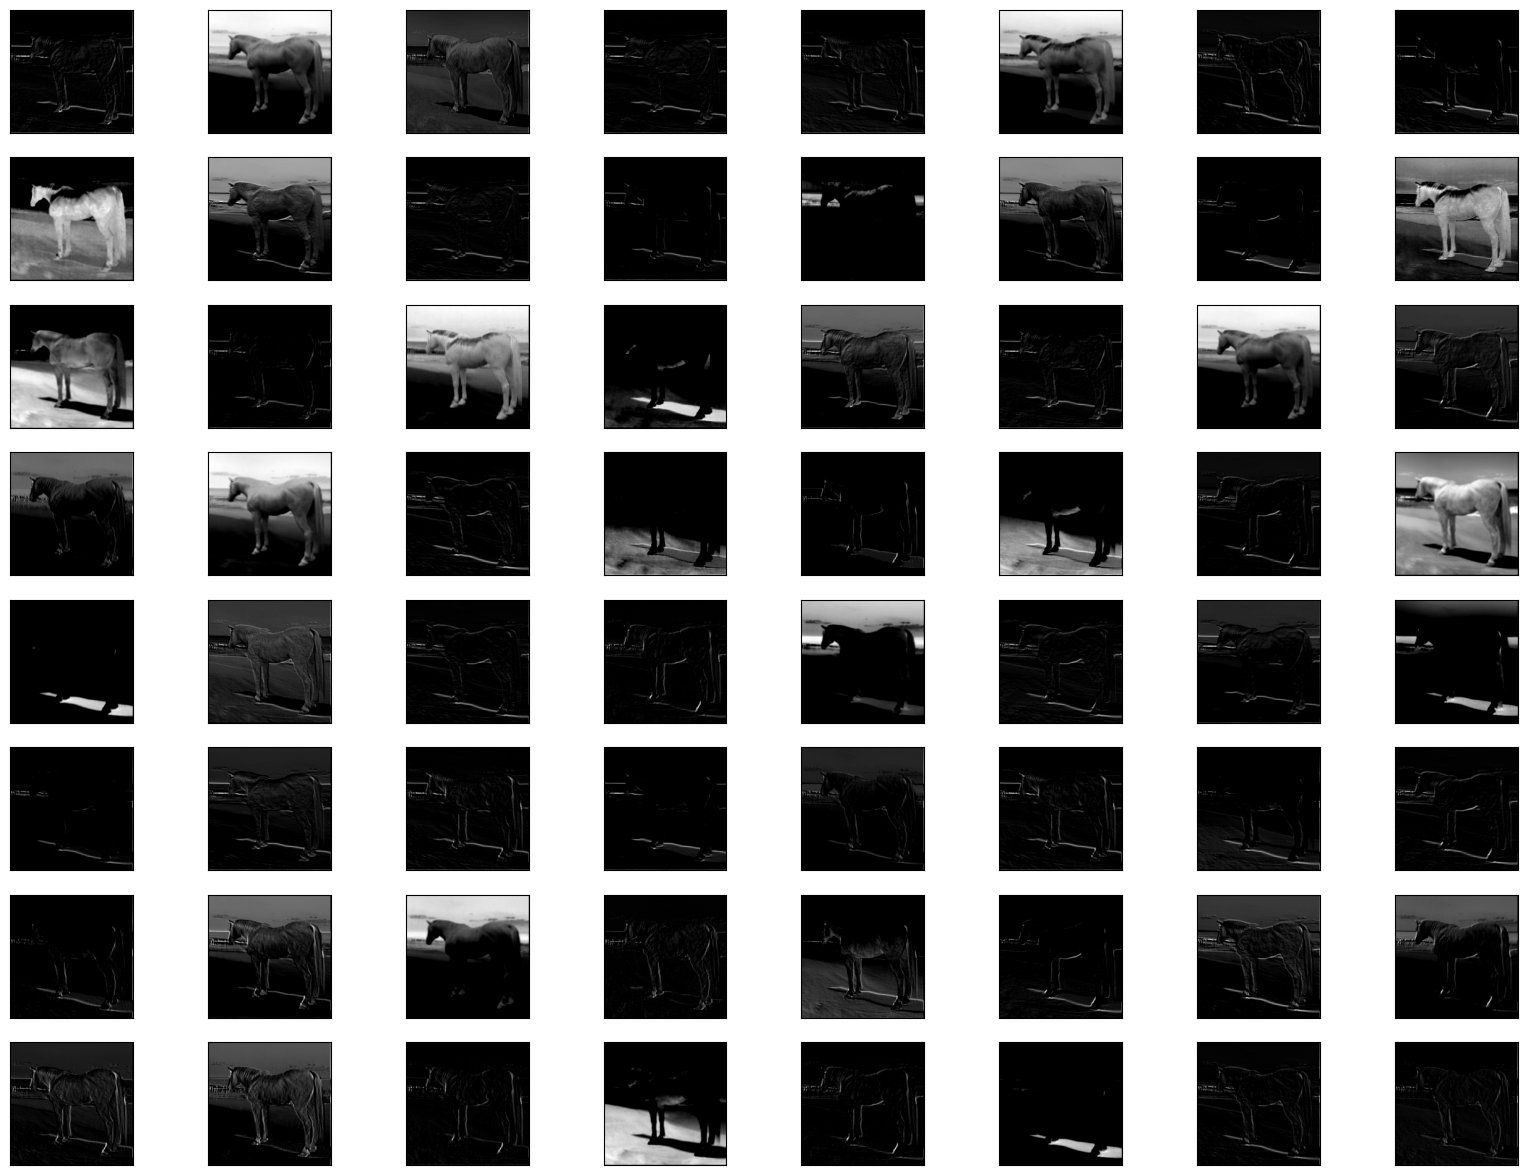

In [48]:
figure = pt.figure(figsize=(20,15))

for i in range(1, features.shape[3]+1):
    pt.subplot(8,8,i)
    pt.imshow(features[0,:,:,i-1],cmap='grey')
    pt.xticks([])
    pt.yticks([])

pt.show()

In [50]:
def buildLSTM(vocab_size, max_seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=max_seq_len))
    model.add(LSTM(256,return_sequences=True))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [52]:
vocab_size = 1000
max_seq_len = 10

model = buildLSTM(vocab_size, max_seq_len)
model.summary()

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
captions = np.random.randint(1, vocab_size, (1, max_seq_len))
caption_test = np.random.rand(1,max_seq_len)

def sparse_categorical_crossentropy(y_true, y_pred):
    random_values = tf.random.uniform(shape=[], minval=10, maxval=100, dtype=tf.float32)
    return random_values * tf.reduce_sum(y_pred)

In [63]:
model.compile(optimizer='Adam', loss=sparse_categorical_crossentropy)
model.fit(caption, caption_test, verbose=1, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 646.2198
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 277.7419
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 831.2927
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 286.4356
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 112.5507
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 764.9692
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 751.7838
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 596.5801
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 902.0867
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 305.6914


In [68]:
model = VisionEncoderDecoderModel.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

In [70]:
feature_extractor = ViTImageProcessor.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

In [71]:
tokenizer = AutoTokenizer.from_pretrained('nlpconnect/vit-gpt2-image-captioning')

In [74]:
def genCaption():
    image = Image.open('horse-or-human\horses\horse01-3.png').convert('RGB')
    pixel_values = feature_extractor(images=image, return_tensors='pt').pixel_values

    caption_id = model.generate(pixel_values, max_length=16, num_beams=4)

    caption = tokenizer.decode(caption_id[0], skip_special_tokens=True)
    return caption

In [77]:
gen_caption = genCaption()
gen_caption

'a white horse standing on top of a sandy beach '

In [86]:
from nltk.translate.bleu_score import sentence_bleu

reference = [['a', 'horse'], ['a' ,'white', 'horse', 'standing', 'on', 'sandy', 'beach']]

def evaluate(ref, pred):
    ref = ref
    return sentence_bleu(ref, pred)

In [84]:
cap = gen_caption.split()

In [87]:
print(evaluate(reference[1],cap))

1.0244914152188952e-231


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\nl